
# Stage 2 – Time Series Anomaly Detection on SMD (ServerMachineDataset)

This notebook implements **Stage 2 – Application of Data Mining Techniques** for a multivariate
time series anomaly detection project, using the **ServerMachineDataset (SMD)** from the
OmniAnomaly repository:

> https://github.com/NetManAIOps/OmniAnomaly/tree/master/ServerMachineDataset

We work with **one machine at a time** (e.g. `machine-1-1`), exactly as in your EDA code,
and we do **not** need to load the entire dataset into memory.

The pipeline is aligned with the KDD process:

1. **Data preparation**
   - Load SMD train / test files for one machine
   - Normalize features using training statistics
   - Build sliding windows (temporal context)
2. **Modeling**
   - Mean reconstruction baseline
   - LSTM autoencoder
   - Transformer-based autoencoder (TranAD-inspired, simplified)
3. **Evaluation**
   - Reconstruction-based anomaly scores
   - Thresholding via high-quantile on training errors
   - Precision, Recall, F1, ROC-AUC, PR-AUC (if labels are available)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# elenco macchine (dal README OmniAnomaly)
files = [f"machine-{i}-{j}.txt"
         for i, j in [(1,k) for k in range(1,9)] +
                      [(2,k) for k in range(1,10)] +
                      [(3,k) for k in range(1,10)]]

# --- TRAIN ---
base_url_train = "https://raw.githubusercontent.com/NetManAIOps/OmniAnomaly/master/ServerMachineDataset/train/"
os.makedirs("data/ServerMachineDataset/train", exist_ok=True)

for fname in files:
    url = base_url_train + fname
    out = f"data/ServerMachineDataset/train/{fname}"
    if not os.path.exists(out):
        print("Downloading train:", url)
        !wget -q {url} -O {out}

# --- TEST ---
base_url_test = "https://raw.githubusercontent.com/NetManAIOps/OmniAnomaly/master/ServerMachineDataset/test/"
os.makedirs("data/ServerMachineDataset/test", exist_ok=True)

for fname in files:
    url = base_url_test + fname
    out = f"data/ServerMachineDataset/test/{fname}"
    if not os.path.exists(out):
        print("Downloading test :", url)
        !wget -q {url} -O {out}

# --- TEST LABEL ---
base_url_label = "https://raw.githubusercontent.com/NetManAIOps/OmniAnomaly/master/ServerMachineDataset/test_label/"
os.makedirs("data/ServerMachineDataset/test_label", exist_ok=True)

for fname in files:
    url = base_url_label + fname
    out = f"data/ServerMachineDataset/test_label/{fname}"
    if not os.path.exists(out):
        print("Downloading label:", url)
        !wget -q {url} -O {out}

# --- INTERPRETATION LABEL (per feature-level diagnosis) ---
base_url_interp = "https://raw.githubusercontent.com/NetManAIOps/OmniAnomaly/master/ServerMachineDataset/interpretation_label/"
os.makedirs("data/ServerMachineDataset/interpretation_label", exist_ok=True)

for fname in files:
    url = base_url_interp + fname
    out = f"data/ServerMachineDataset/interpretation_label/{fname}"
    if not os.path.exists(out):
        print("Downloading interp:", url)
        !wget -q {url} -O {out}



## Notebook Outline

1. [Setup & Configuration](#setup)
2. [SMD Data Loading (single machine)](#data-loading)
3. [Preprocessing: Normalization & Sliding Windows](#preprocessing)
4. [PyTorch Dataset & DataLoaders](#dataset)
5. [Models](#models)
   - Mean Reconstruction Baseline
   - LSTM Autoencoder
   - Transformer Autoencoder
6. [Training & Validation Loop](#training)
7. [Anomaly Scoring & Evaluation Metrics](#evaluation)
8. [End-to-End Experiment Pipeline on One SMD Machine](#pipeline)


## 1. Setup & Configuration<a id='setup'></a>

In [ ]:

import os
from typing import Tuple, Optional, Dict
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import (
    precision_recall_fscore_support,
    roc_auc_score,
    average_precision_score,
)

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Helper function for sinusoidal positional encoding
def sinusoidal_pos_encoding(max_len, d_model):
    position = torch.arange(max_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
    pe = torch.zeros(max_len, d_model)
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe.unsqueeze(0) # (1, max_len, d_model)


Using device: cuda



## 2. SMD Data Loading (single machine)<a id='data-loading'></a>

The original **SMD** structure (from the OmniAnomaly repo) is:

- `ServerMachineDataset/train/machine-x-y.txt` – training data (normal only)
- `ServerMachineDataset/test/machine-x-y.txt` – test data (with anomalies)
- `ServerMachineDataset/test_label/machine-x-y.txt` – test labels (0 = normal, 1 = anomaly)
- `ServerMachineDataset/interpretation_label/machine-x-y.txt` – detailed feature-level anomaly info

We define a loader that:

1. Reads the `train` and `test` `.txt` files for a single machine.
2. Optionally reads `test_label` if available to build a 0/1 label vector.
3. Returns NumPy arrays `(train_data, test_data, test_labels)`.


In [ ]:
from pathlib import Path

def load_smd_machine(
    train_dir: str,
    machine_id: str = "machine-1-1",
    test_dir: str = None,
    label_dir: str = None,
):
    """
    Load SMD data for a single machine, using the same folder structure
    you already used in your EDA notebook.

    Parameters
    ----------
    train_dir : str
        Folder that contains the training .txt files, e.g. "data/ServerMachineDataset/train".
    machine_id : str
        Machine identifier, e.g. "machine-1-1".
    test_dir : str, optional
        Folder that contains the test .txt files. If None, defaults to parent of train_dir / "test".
    label_dir : str, optional
        Folder that contains the test_label .txt files. If None, defaults to parent of train_dir / "test_label".

    Returns
    -------
    train_data : np.ndarray (T_train, D)
    test_data  : np.ndarray (T_test, D) or None if test file not found
    test_labels : np.ndarray (T_test,) or None if label file not found
    """
    train_dir = Path(train_dir)

    if test_dir is None:
        test_dir = train_dir.parent / "test"
    else:
        test_dir = Path(test_dir)

    if label_dir is None:
        label_dir = train_dir.parent / "test_label"
    else:
        label_dir = Path(label_dir)

    train_path = train_dir / f"{machine_id}.txt"
    test_path = test_dir / f"{machine_id}.txt"
    label_path = label_dir / f"{machine_id}.txt"

    if not train_path.exists():
        raise FileNotFoundError(f"Train file not found: {train_path}")

    train_df = pd.read_csv(train_path, header=None)
    train_data = train_df.values.astype(np.float32)

    print(f"Loaded SMD machine {machine_id}")
    print("Train shape:", train_data.shape)

    # Test may or may not exist
    if test_path.exists():
        test_df = pd.read_csv(test_path, header=None)
        test_data = test_df.values.astype(np.float32)
        print("Test  shape:", test_data.shape)
    else:
        print(f"⚠️ Test file not found: {test_path} – using None.")
        test_data = None

    # Labels may or may not exist
    if label_path.exists():
        labels_df = pd.read_csv(label_path, header=None)
        test_labels = labels_df.values.squeeze().astype(int)
        print("Labels shape:", test_labels.shape)
        print("Number of anomalous points in test:", int(test_labels.sum()))
    else:
        print(f"⚠️ Label file not found: {label_path} – using None.")
        test_labels = None

    return train_data, test_data, test_labels


## 3. Preprocessing: Normalization & Sliding Windows<a id='preprocessing'></a>

We now:

1. **Normalize** each feature using **min-max normalization** (based only on the training set):
   \[
   x_t' = \frac{x_t - \min(T)}{\max(T) - \min(T) + \epsilon}
   \]
2. **Create sliding windows** of length \(K\) for each time step, with *replication padding*
   at the beginning of the series.


In [ ]:

def min_max_normalize(train: np.ndarray, test: np.ndarray, eps: float = 1e-8):
    '''
    Min-max normalization per feature, using only training data statistics.
    '''
    data_min = train.min(axis=0, keepdims=True)
    data_max = train.max(axis=0, keepdims=True)

    train_norm = (train - data_min) / (data_max - data_min + eps)
    test_norm = (test - data_min) / (data_max - data_min + eps)

    return train_norm.astype(np.float32), test_norm.astype(np.float32), data_min, data_max


def create_sliding_windows(
    data: np.ndarray, window_size: int
) -> np.ndarray:
    '''
    Create sliding windows of length K for each time step t, with replication padding.
    '''
    T, D = data.shape
    K = window_size
    windows = np.zeros((T, K, D), dtype=np.float32)

    for t in range(T):
        start = t - K + 1
        if start < 0:
            pad_len = -start
            windows[t, :pad_len, :] = data[0:1, :]
            windows[t, pad_len:, :] = data[0:t+1, :]
        else:
            windows[t] = data[start:t+1, :]

    return windows



## 4. PyTorch Dataset & DataLoaders<a id='dataset'></a>


In [ ]:

class TimeSeriesWindowDataset(Dataset):
    '''
    A simple dataset returning one window (K, D) at a time.
    '''
    def __init__(self, windows: np.ndarray):
        self.windows = windows

    def __len__(self):
        return self.windows.shape[0]

    def __getitem__(self, idx):
        x = self.windows[idx]
        return torch.from_numpy(x)


def create_dataloaders(
    train_windows: np.ndarray,
    batch_size: int = 128,
    val_ratio: float = 0.2,
):
    '''
    Split training windows into train/val (e.g., 80/20) and create DataLoaders.
    '''
    T = train_windows.shape[0]
    val_len = int(T * val_ratio)
    train_len = T - val_len

    train_w = train_windows[:train_len]
    val_w = train_windows[train_len:]

    train_ds = TimeSeriesWindowDataset(train_w)
    val_ds = TimeSeriesWindowDataset(val_w)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, drop_last=False)

    return train_loader, val_loader



## 5. Models<a id='models'></a>

We define three models of increasing complexity:


In [ ]:

class MeanReconstructionBaseline(nn.Module):
    '''
    Baseline: reconstruct each window as its feature-wise mean along the time dimension.
    '''
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # x: (B, K, D)
        mean = x.mean(dim=1, keepdim=True)  # (B, 1, D)
        return mean.repeat(1, x.shape[1], 1)


5.1 **LSTM autoecnoder**

In [ ]:

class LSTMAutoencoder(nn.Module):
    '''
    LSTM-based autoencoder for sequence reconstruction.
    '''
    def __init__(self, input_dim: int, hidden_dim: int = 64, latent_dim: int = 32, num_layers: int = 1):
        super().__init__()
        self.encoder = nn.LSTM(
            input_dim, hidden_dim, num_layers=num_layers, batch_first=True
        )
        self.enc_to_latent = nn.Linear(hidden_dim, latent_dim)

        self.latent_to_dec = nn.Linear(latent_dim, hidden_dim)
        self.decoder = nn.LSTM(
            hidden_dim, input_dim, num_layers=num_layers, batch_first=True
        )

    def forward(self, x):
        # x: (B, K, D)
        enc_out, _ = self.encoder(x)          # enc_out: (B, K, H)
        h_last = enc_out[:, -1, :]            # last hidden state (B, H)
        z = self.enc_to_latent(h_last)        # (B, latent)

        # Decoder: repeat latent over K time steps
        dec_init = self.latent_to_dec(z).unsqueeze(1)  # (B,1,H)
        K = x.shape[1]
        dec_input = dec_init.repeat(1, K, 1)           # (B,K,H)

        dec_out, _ = self.decoder(dec_input)           # (B,K,D)
        return dec_out


5.2 **Trasformer-based Autoecoder** (based on TranAD)

In [ ]:

class TransformerAEPlain(nn.Module):
    '''
    Simplified Transformer-based autoencoder (TranAD-inspired).
    '''
    def __init__(
        self,
        input_dim: int,
        d_model: int = 64,
        nhead: int = 4,
        num_layers: int = 1,
        dim_feedforward: int = 128,
        dropout: float = 0.1,
        max_len: int = 512,
    ):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model

        self.input_projection = nn.Linear(input_dim, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        self.output_projection = nn.Linear(d_model, input_dim)

        # Learnable positional embeddings
        self.pos_embedding = nn.Embedding(max_len, d_model)

    def forward(self, x):
        # x: (B, K, D)
        B, K, D = x.shape
        pos_ids = torch.arange(0, K, device=x.device).unsqueeze(0).repeat(B, 1)  # (B,K)

        x_proj = self.input_projection(x) + self.pos_embedding(pos_ids)         # (B,K,d_model)

        memory = self.encoder(x_proj)                                           # (B,K,d_model)
        out = self.decoder(tgt=x_proj, memory=memory)                           # (B,K,d_model)
        recon = self.output_projection(out)                                     # (B,K,D)
        return recon


5.3 **Trasformer with Layernorm** for improving results
Key differences.
Our LayerNorm-based transformer differs from the plain version in three main aspects:

1. It uses a learnable positional embedding of shape
1×𝐾×𝑑 model 1×K×d model (with K=10 in our experiments), instead of a large fixed embedding table.

2. We enable norm_first=True, so Layer Normalisation is applied before the self-attention and feed-forward blocks, which stabilises the internal activations.

3. We add a final LayerNorm (final_norm) on the decoder output, which further stabilises the reconstructed time series.

These changes make the transformer much more numerically stable, significantly reducing extreme reconstruction errors while preserving overall reconstruction quality.

In [ ]:
##version corrected
import torch
import torch.nn as nn

class TransformerAELN(nn.Module):
    def __init__(self, input_dim=38, d_model=64, nhead=4, num_layers=1):
        super().__init__()

        # === Input projection ===
        self.input_proj = nn.Linear(input_dim, d_model)

        # === Learned positional embeddings ===
        self.pos_embedding = nn.Parameter(torch.randn(1, 10, d_model))

        # === Encoder (with LayerNorm) ===
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True,
            dropout=0.1,
            norm_first=True   # <-- IMPORTANT
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # === Decoder (with LayerNorm) ===
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True,
            dropout=0.1,
            norm_first=True   # <-- IMPORTANT
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        # === Output projection ===
        self.output_proj = nn.Linear(d_model, input_dim)

        # === Final normalization (helps stability) ===
        self.final_norm = nn.LayerNorm(input_dim)

    def forward(self, x):
        # x: (batch, seq, features)

        # Input → latent
        x = self.input_proj(x) + self.pos_embedding

        # Encode
        z = self.encoder(x)

        # Decode using encoded representation as memory
        out = self.decoder(tgt=x, memory=z)

        # Output projection + final stability norm
        out = self.output_proj(out)
        out = self.final_norm(out)

        return out



## 6. Training & Validation Loop<a id='training'></a>


In [ ]:

def train_epoch(
    model: nn.Module,
    dataloader: DataLoader,
    optimizer: Optional[torch.optim.Optimizer],
    criterion: nn.Module,
    train_mode: bool = True,
) -> float:
    '''
    Run one training or validation epoch.
    '''
    model.train(train_mode)
    total_loss = 0.0
    n_samples = 0

    for batch in dataloader:
        x = batch.to(device).float()
        recon = model(x)
        loss = criterion(recon, x)

        if train_mode and optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * x.size(0)
        n_samples += x.size(0)

    return total_loss / n_samples


def fit_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    num_epochs: int = 20,
    lr: float = 1e-3,
    weight_decay: float = 1e-5,
) -> Dict[str, list]:
    '''
    Full training loop for an autoencoder-style model.
    '''
    model.to(device)

    if any(p.requires_grad for p in model.parameters()):
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        optimizer = None

    criterion = nn.MSELoss()
    history = {"train_loss": [], "val_loss": []}

    for epoch in range(1, num_epochs + 1):
        train_loss = train_epoch(
            model,
            train_loader,
            optimizer,
            criterion,
            train_mode=(optimizer is not None),
        )
        val_loss = train_epoch(
            model,
            val_loader,
            optimizer=None,
            criterion=criterion,
            train_mode=False,
        )

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)

        print(
            f"Epoch {epoch:03d} | train_loss={train_loss:.6f} | val_loss={val_loss:.6f}"
        )

    return history


**Huber fit model** for 8.6.2

In [ ]:
import torch.nn as nn

def fit_model_huber(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    num_epochs: int = 20,
    lr: float = 1e-3,
    weight_decay: float = 1e-5,
    delta: float = 1.0,   # parametro di Huber
) -> Dict[str, list]:
    """
    Training loop using SmoothL1Loss (Huber loss) for robustness.
    """
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.SmoothL1Loss()   # Huber

    history = {"train_loss": [], "val_loss": []}

    for epoch in range(1, num_epochs + 1):
        train_loss = train_epoch(model, train_loader, optimizer, criterion, train_mode=True)
        val_loss   = train_epoch(model, val_loader,   optimizer=None,   criterion=criterion, train_mode=False)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)

        print(f"[Huber] Epoch {epoch:03d} | train_loss={train_loss:.6f} | val_loss={val_loss:.6f}")

    return history

**Position encoding traformer** for 8.6.4

In [ ]:
#function needed to define de positional encoding

def sinusoidal_pos_encoding(max_len: int, d_model: int, device=None):
    """
    Classic sinusoidal positional encoding (Vaswani et al.).
    Returns tensor of shape (1, max_len, d_model).
    """
    if device is None:
        device = torch.device("cpu")

    pe = torch.zeros(max_len, d_model, device=device)
    position = torch.arange(0, max_len, dtype=torch.float, device=device).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2, device=device).float() * (-np.log(10000.0) / d_model))

    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)

    pe = pe.unsqueeze(0)  # (1, max_len, d_model)
    return pe


In [ ]:
class TransformerAEMixedPos(nn.Module):
    """
    Transformer AE with LayerNorm and mixed positional encoding
    (learnable + sinusoidal).
    """
    def __init__(self, input_dim=38, d_model=64, nhead=4, num_layers=1, max_len=10):
        super().__init__()

        self.input_proj = nn.Linear(input_dim, d_model)

        self.pos_learned = nn.Parameter(torch.randn(1, max_len, d_model))
        self.register_buffer("pos_sinusoidal", sinusoidal_pos_encoding(max_len, d_model))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True,
            dropout=0.1,
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True,
            dropout=0.1,
            norm_first=True
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        self.output_proj = nn.Linear(d_model, input_dim)
        self.final_norm = nn.LayerNorm(input_dim)

    def forward(self, x):
        # x: (B, K, D), K <= max_len
        B, K, _ = x.shape
        pos_learned = self.pos_learned[:, :K, :]
        pos_sinus   = self.pos_sinusoidal[:, :K, :]
        pos = pos_learned + pos_sinus

        x = self.input_proj(x) + pos
        z = self.encoder(x)
        out = self.decoder(tgt=x, memory=z)
        out = self.output_proj(out)
        out = self.final_norm(out)
        return out



## 7. **Anomaly Scoring & Evaluation Metrics<a id='evaluation'></a>**



### 7.1 Feature-level (dimension-wise) anomaly diagnosis

In addition to a single anomaly score per timestamp, we can also analyze **which dimensions**
(features) contribute most to the reconstruction error.

We do this by:
- Computing the **MSE per feature** (averaged over the window length).
- Learning a **separate threshold per feature** from the training set.
- Producing a **multi-label prediction** matrix of shape `(T, D)` where each entry
  indicates whether a given feature is anomalous at a given time step.


In [ ]:

def compute_feature_level_errors(
    model: nn.Module,
    windows: np.ndarray,
) -> np.ndarray:
    '''
    Compute reconstruction errors per feature (dimension) for each window/time step.

    Parameters
    ----------
    model : nn.Module
        Trained reconstruction model (e.g. LSTMAutoencoder, TransformerAutoencoder).
    windows : np.ndarray
        Sliding windows of shape (T, K, D).

    Returns
    -------
    feature_errors : np.ndarray
        Array of shape (T, D), where each entry [t, d] is the average MSE for
        feature d over the K positions in the window ending at time t.
    '''
    model.to(device)
    model.eval()

    ds = TimeSeriesWindowDataset(windows)
    loader = DataLoader(ds, batch_size=256, shuffle=False, drop_last=False)

    all_feat_errors = []
    criterion = nn.MSELoss(reduction="none")

    with torch.no_grad():
        for batch in loader:
            x = batch.to(device).float()           # (B,K,D)
            recon = model(x)
            loss_per_element = criterion(recon, x) # (B,K,D)
            # average over time dimension K, keep feature dimension D
            loss_per_feature = loss_per_element.mean(dim=1)  # (B,D)
            all_feat_errors.append(loss_per_feature.cpu().numpy())

    feature_errors = np.concatenate(all_feat_errors, axis=0)  # (T,D)
    return feature_errors


def choose_feature_thresholds(
    train_feature_errors: np.ndarray,
    quantile: float = 0.995,
) -> np.ndarray:
    '''
    Choose a separate threshold for each feature based on training feature-level errors.

    Parameters
    ----------
    train_feature_errors : np.ndarray
        Array of shape (T_train, D) with feature-wise errors.
    quantile : float
        High quantile used as threshold per feature.

    Returns
    -------
    thresholds : np.ndarray
        Array of shape (D,) with one threshold per feature.
    '''
    # quantile along time (axis=0), for each feature
    thresholds = np.quantile(train_feature_errors, quantile, axis=0)
    return thresholds.astype(np.float32)


def compute_feature_level_predictions(
    feature_errors: np.ndarray,
    thresholds: np.ndarray,
) -> np.ndarray:
    '''
    Multi-label (dimension-wise) anomaly predictions.

    Parameters
    ----------
    feature_errors : np.ndarray
        Array of shape (T, D) with feature-wise anomaly scores.
    thresholds : np.ndarray
        Array of shape (D,) with thresholds per feature.

    Returns
    -------
    y_pred_feat : np.ndarray
        Binary matrix of shape (T, D), where y_pred_feat[t, d] = 1 if feature d
        is anomalous at time t.
    '''
    # Broadcast thresholds over time dimension
    return (feature_errors >= thresholds[np.newaxis, :]).astype(int)


7.2 Compute recunstroction errors

In [ ]:

def compute_reconstruction_errors(
    model: nn.Module,
    windows: np.ndarray,
) -> np.ndarray:
    '''
    Compute reconstruction errors (MSE) per window/time step.
    '''
    model.to(device)
    model.eval()

    ds = TimeSeriesWindowDataset(windows)
    loader = DataLoader(ds, batch_size=256, shuffle=False, drop_last=False)

    all_errors = []
    criterion = nn.MSELoss(reduction="none")

    with torch.no_grad():
        for batch in loader:
            x = batch.to(device).float()
            recon = model(x)
            loss_per_element = criterion(recon, x)      # (B,K,D)
            loss_per_window = loss_per_element.mean(dim=(1, 2))  # (B,)
            all_errors.append(loss_per_window.cpu().numpy())

    errors = np.concatenate(all_errors, axis=0)
    return errors


def choose_threshold(errors: np.ndarray, quantile: float = 0.995) -> float:
    '''
    Choose a high-quantile threshold from training reconstruction errors.
    '''
    return np.quantile(errors, quantile)


def compute_predictions(errors: np.ndarray, threshold: float) -> np.ndarray:
    '''
    Map anomaly scores to binary predictions via threshold.
    '''
    return (errors >= threshold).astype(int)


def evaluate_anomaly_detection(
    y_true: np.ndarray,
    scores: np.ndarray,
    y_pred: np.ndarray,
) -> Dict[str, float]:
    '''
    Compute Precision, Recall, F1, ROC-AUC, and PR-AUC.
    '''
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )

    try:
        auc_roc = roc_auc_score(y_true, scores)
    except ValueError:
        auc_roc = float("nan")

    try:
        auc_pr = average_precision_score(y_true, scores)
    except ValueError:
        auc_pr = float("nan")

    return {
        "precision": float(precision),
        "recall": float(recall),
        "f1": float(f1),
        "auc_roc": float(auc_roc),
        "auc_pr": float(auc_pr),
    }



## 8. End-to-End Experiment Pipeline on One SMD Machine<a id='pipeline'></a>

In this final section you can:

- Select the **SMD root** and a **machine_id** (e.g. `machine-1-1`).
- Run the full Stage-2 pipeline for that machine.


In [ ]:
import os

# Path to the root of the ServerMachineDataset (parent of 'train', 'test', 'test_label')
# This path now assumes the data was downloaded to the local Colab filesystem by a previous cell.
SMD_ROOT = "data/ServerMachineDataset" # Adjusted to reflect downloaded data location
SMD_TRAIN_DIR = os.path.join(SMD_ROOT, "train")
MACHINE_ID = "machine-1-1"  # or the machine you have chosen

WINDOW_SIZE = 10
BATCH_SIZE = 128
EPOCHS = 20

print("SMD_ROOT:", SMD_ROOT)
print("SMD_TRAIN_DIR:", SMD_TRAIN_DIR)
print("MACHINE_ID:", MACHINE_ID)


SMD_ROOT: data/ServerMachineDataset
SMD_TRAIN_DIR: data/ServerMachineDataset/train
MACHINE_ID: machine-1-1


Loaded SMD machine machine-1-1
Train shape: (28479, 38)
Test  shape: (28479, 38)
Labels shape: (28479,)
Number of anomalous points in test: 2694
train_norm: (28479, 38)
test_norm : (28479, 38)


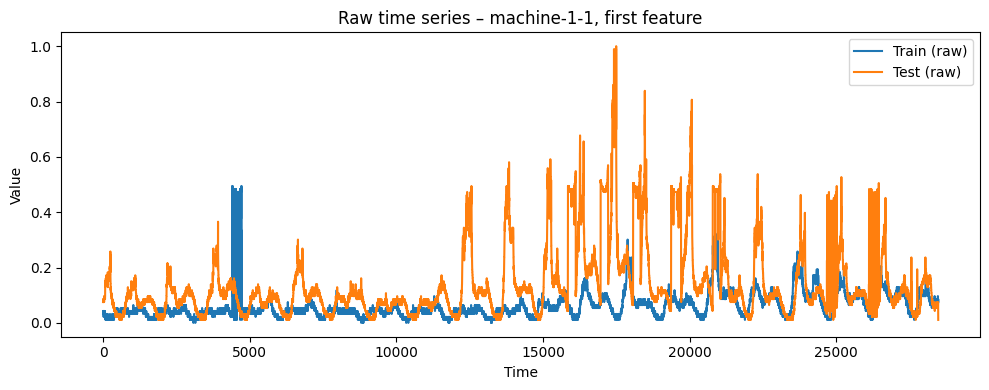

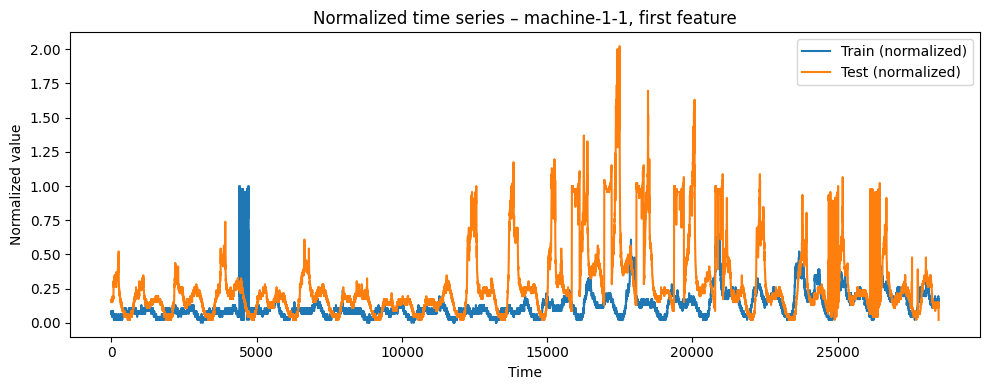

In [ ]:

# ==== 8.2 Load & Normalize Data ====

from pathlib import Path

# Use the SMD_TRAIN_DIR defined in the previous section, which correctly points to the 'train' subdirectory
train_data, test_data, test_labels = load_smd_machine(SMD_TRAIN_DIR, MACHINE_ID)

# Normalize using training statistics
train_norm, test_norm, data_min, data_max = min_max_normalize(train_data, test_data)

print("train_norm:", train_norm.shape)
print("test_norm :", test_norm.shape)

# Quick sanity check on first feature
plt.figure(figsize=(10, 4))
plt.plot(train_data[:, 0], label="Train (raw)")
plt.plot(test_data[:, 0], label="Test (raw)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title(f"Raw time series – {MACHINE_ID}, first feature")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(train_norm[:, 0], label="Train (normalized)")
plt.plot(test_norm[:, 0], label="Test (normalized)")
plt.xlabel("Time")
plt.ylabel("Normalized value")
plt.title(f"Normalized time series – {MACHINE_ID}, first feature")
plt.legend()
plt.tight_layout()
plt.show()


# 8.3 Creating Sliding Windows

In [ ]:

# ==== 8.3 Create Sliding Windows & DataLoaders ====

train_windows = create_sliding_windows(train_norm, WINDOW_SIZE)
test_windows = create_sliding_windows(test_norm, WINDOW_SIZE)

print("Train windows shape:", train_windows.shape)
print("Test  windows shape:", test_windows.shape)

train_loader, val_loader = create_dataloaders(
    train_windows, batch_size=BATCH_SIZE, val_ratio=0.2
)

input_dim = train_data.shape[1]
print("Input dimension (features):", input_dim)


Train windows shape: (28479, 10, 38)
Test  windows shape: (28479, 10, 38)
Input dimension (features): 38


# 8.4 **Mean Recunstruction Baseline**

In [ ]:

# ==== 8.4 Mean Reconstruction Baseline ====

print("\n=== Mean Reconstruction Baseline ===")
mean_model = MeanReconstructionBaseline()
_ = fit_model(mean_model, train_loader, val_loader, num_epochs=1)

train_errors_mean = compute_reconstruction_errors(mean_model, train_windows)
test_errors_mean = compute_reconstruction_errors(mean_model, test_windows)

# quick sanity check on error scale
test_scores = test_errors_mean # Corrected: use test_errors_mean for the Mean Baseline
print("Huge values:", np.sum(test_scores > 10))
print("min / max:", test_scores.min(), test_scores.max())

if test_labels is not None:
    thr_mean = choose_threshold(train_errors_mean, quantile=0.995)
    y_pred_mean = compute_predictions(test_errors_mean, thr_mean)
    metrics_mean = evaluate_anomaly_detection(test_labels, test_errors_mean, y_pred_mean)
    print("Mean baseline metrics:", metrics_mean)
else:
    print("No labels available: skipping metric computation for baseline.")



=== Mean Reconstruction Baseline ===
Epoch 001 | train_loss=0.000665 | val_loss=0.000736
Huge values: 480
min / max: 2.2350545e-16 73592080000000.0
Mean baseline metrics: {'precision': 0.5684257602862254, 'recall': 0.4717891610987379, 'f1': 0.5156186612576065, 'auc_roc': 0.9105175730035319, 'auc_pr': 0.5767005550490445}


# 8.5 **LSTM Autoecoder**

In [ ]:

# ==== 8.5 LSTM Autoencoder ====

print("\n=== LSTM Autoencoder ===")
lstm_model = LSTMAutoencoder(input_dim=input_dim, hidden_dim=64, latent_dim=32)
hist_lstm = fit_model(lstm_model, train_loader, val_loader, num_epochs=EPOCHS, lr=1e-3)

train_errors_lstm = compute_reconstruction_errors(lstm_model, train_windows)
test_errors_lstm = compute_reconstruction_errors(lstm_model, test_windows)

# quick sanity check on error scale
test_scores = test_errors_lstm # Corrected: use test_errors_lstm for the LSTM Autoencoder
print("Huge values:", np.sum(test_scores > 10))
print("min / max:", test_scores.min(), test_scores.max())

if test_labels is not None:
    thr_lstm = choose_threshold(train_errors_lstm, quantile=0.995)
    y_pred_lstm = compute_predictions(test_errors_lstm, thr_lstm)
    metrics_lstm = evaluate_anomaly_detection(test_labels, test_errors_lstm, y_pred_lstm)
    print("LSTM metrics:", metrics_lstm)
else:
    print("No labels available: skipping metric computation for LSTM.")



=== LSTM Autoencoder ===
Epoch 001 | train_loss=0.010115 | val_loss=0.002465
Epoch 002 | train_loss=0.002010 | val_loss=0.001854
Epoch 003 | train_loss=0.001383 | val_loss=0.001613
Epoch 004 | train_loss=0.001245 | val_loss=0.001526
Epoch 005 | train_loss=0.001197 | val_loss=0.001517
Epoch 006 | train_loss=0.001151 | val_loss=0.001475
Epoch 007 | train_loss=0.001104 | val_loss=0.001432
Epoch 008 | train_loss=0.001068 | val_loss=0.001427
Epoch 009 | train_loss=0.001042 | val_loss=0.001344
Epoch 010 | train_loss=0.001026 | val_loss=0.001349
Epoch 011 | train_loss=0.001019 | val_loss=0.001402
Epoch 012 | train_loss=0.001005 | val_loss=0.001341
Epoch 013 | train_loss=0.001004 | val_loss=0.001374
Epoch 014 | train_loss=0.000993 | val_loss=0.001302
Epoch 015 | train_loss=0.000987 | val_loss=0.001334
Epoch 016 | train_loss=0.000981 | val_loss=0.001303
Epoch 017 | train_loss=0.000978 | val_loss=0.001287
Epoch 018 | train_loss=0.000973 | val_loss=0.001329
Epoch 019 | train_loss=0.000968 | val_

# 8.6 Testing **trasfromer with LayerNrom**

In [ ]:

# ==== 8.6 Transformer Autoencoder ====

print("\n=== Transformer Autoencoder (with LayerNorm) ===")
transf_model = TransformerAELN(
    input_dim=input_dim,
    d_model=64,
    nhead=4,
    num_layers=1
)

hist_transf = fit_model(transf_model, train_loader, val_loader, num_epochs=EPOCHS, lr=1e-3)

train_errors_transf = compute_reconstruction_errors(transf_model, train_windows)
test_errors_transf  = compute_reconstruction_errors(transf_model,  test_windows)

# quick sanity check on error scale
test_scores = test_errors_transf
print("Huge values:", np.sum(test_scores > 10))
print("min / max:", test_scores.min(), test_scores.max())

if test_labels is not None:
    thr_transf = choose_threshold(train_errors_transf, quantile=0.995)
    y_pred_transf = compute_predictions(test_errors_transf, thr_transf)
    metrics_transf = evaluate_anomaly_detection(test_labels, test_errors_transf, y_pred_transf)
    print("Transformer metrics:", metrics_transf)
else:
    print("No labels available: skipping metric computation for Transformer.")



=== Transformer Autoencoder (with LayerNorm) ===


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 001 | train_loss=0.481243 | val_loss=0.287933
Epoch 002 | train_loss=0.161413 | val_loss=0.056386
Epoch 003 | train_loss=0.021037 | val_loss=0.012667
Epoch 004 | train_loss=0.005106 | val_loss=0.009227
Epoch 005 | train_loss=0.004010 | val_loss=0.008215
Epoch 006 | train_loss=0.003656 | val_loss=0.007489
Epoch 007 | train_loss=0.003237 | val_loss=0.006875
Epoch 008 | train_loss=0.002893 | val_loss=0.006499
Epoch 009 | train_loss=0.002645 | val_loss=0.006128
Epoch 010 | train_loss=0.002461 | val_loss=0.005898
Epoch 011 | train_loss=0.002309 | val_loss=0.005635
Epoch 012 | train_loss=0.002163 | val_loss=0.005316
Epoch 013 | train_loss=0.001992 | val_loss=0.004895
Epoch 014 | train_loss=0.001714 | val_loss=0.003997
Epoch 015 | train_loss=0.001150 | val_loss=0.002535
Epoch 016 | train_loss=0.000868 | val_loss=0.001829
Epoch 017 | train_loss=0.000771 | val_loss=0.001468
Epoch 018 | train_loss=0.000700 | val_loss=0.001228
Epoch 019 | train_loss=0.000614 | val_loss=0.001040
Epoch 020 | 

**Trasformer with more dropout** for 8.6.3

In [ ]:
class TransformerAELNDrop(nn.Module):
    """
    Transformer autoencoder with LayerNorm and higher dropout.
    """
    def __init__(self, input_dim=38, d_model=64, nhead=4, num_layers=1, dropout=0.3):
        super().__init__()

        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_embedding = nn.Parameter(torch.randn(1, 10, d_model))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True,
            dropout=dropout,
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True,
            dropout=dropout,
            norm_first=True
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        self.output_proj = nn.Linear(d_model, input_dim)
        self.final_norm = nn.LayerNorm(input_dim)

    def forward(self, x):
        x = self.input_proj(x) + self.pos_embedding
        z = self.encoder(x)
        out = self.decoder(tgt=x, memory=z)
        out = self.output_proj(out)
        out = self.final_norm(out)
        return out


In [ ]:
import torch
import numpy as np

print("PyTorch version:", torch.__version__)
print("NumPy version:", np.__version__)

PyTorch version: 2.9.0+cu126
NumPy version: 2.0.2


# 8.6.1 **+ more epochs**

In [ ]:
# ==== 8.6.1 Transformer (LayerNorm) – more epochs ====

EPOCHS_TRANSF_LONG = 40

transf_model_long = TransformerAELN(
    input_dim=input_dim,
    d_model=64,
    nhead=4,
    num_layers=1
)

hist_transf_long = fit_model(
    transf_model_long,
    train_loader,
    val_loader,
    num_epochs=EPOCHS_TRANSF_LONG,
    lr=1e-3
)

train_errors_transf_long = compute_reconstruction_errors(transf_model_long, train_windows)
test_errors_transf_long  = compute_reconstruction_errors(transf_model_long, test_windows)

# sanity check
print("[Transf-long] Huge values:", np.sum(test_errors_transf_long > 10))
print("[Transf-long] min / max:", test_errors_transf_long.min(), test_errors_transf_long.max())

if test_labels is not None:
    thr_transf_long    = choose_threshold(train_errors_transf_long, quantile=0.995)
    y_pred_transf_long = compute_predictions(test_errors_transf_long, thr_transf_long)
    metrics_transf_long = evaluate_anomaly_detection(test_labels, test_errors_transf_long, y_pred_transf_long)
    print("Transformer (40 epochs) metrics:", metrics_transf_long)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 001 | train_loss=0.480433 | val_loss=0.289212
Epoch 002 | train_loss=0.164714 | val_loss=0.065598
Epoch 003 | train_loss=0.024987 | val_loss=0.013272
Epoch 004 | train_loss=0.005587 | val_loss=0.008108
Epoch 005 | train_loss=0.004231 | val_loss=0.007467
Epoch 006 | train_loss=0.003886 | val_loss=0.007065
Epoch 007 | train_loss=0.003532 | val_loss=0.006533
Epoch 008 | train_loss=0.003188 | val_loss=0.005971
Epoch 009 | train_loss=0.002887 | val_loss=0.005416
Epoch 010 | train_loss=0.002538 | val_loss=0.004592
Epoch 011 | train_loss=0.001719 | val_loss=0.002781
Epoch 012 | train_loss=0.001109 | val_loss=0.002007
Epoch 013 | train_loss=0.000963 | val_loss=0.001650
Epoch 014 | train_loss=0.000899 | val_loss=0.001494
Epoch 015 | train_loss=0.000862 | val_loss=0.001407
Epoch 016 | train_loss=0.000831 | val_loss=0.001340
Epoch 017 | train_loss=0.000804 | val_loss=0.001304
Epoch 018 | train_loss=0.000772 | val_loss=0.001213
Epoch 019 | train_loss=0.000730 | val_loss=0.001125
Epoch 020 | 

In [ ]:
print("hist_lstm  in globals?  ", 'hist_lstm' in globals())
print("hist_transf in globals? ", 'hist_transf' in globals())
print("lstm_model in globals? ", 'lstm_model' in globals())
print("transf_model in globals?", 'transf_model' in globals())


hist_lstm  in globals?   True
hist_transf in globals?  True
lstm_model in globals?  True
transf_model in globals? True


# 8.6.2 **+ Huber loss**

In [ ]:

transf_model_huber = TransformerAELN(
    input_dim=input_dim,
    d_model=64,
    nhead=4,
    num_layers=1
)

hist_transf_huber = fit_model_huber(
    transf_model_huber,
    train_loader,
    val_loader,
    num_epochs=EPOCHS,   # es. 20
    lr=1e-3
)

train_errors_transf_huber = compute_reconstruction_errors(transf_model_huber, train_windows)
test_errors_transf_huber  = compute_reconstruction_errors(transf_model_huber,  test_windows)

print("[Transf-huber] Huge values:", np.sum(test_errors_transf_huber > 10))
print("[Transf-huber] min / max:", test_errors_transf_huber.min(), test_errors_transf_huber.max())

if test_labels is not None:
    thr_transf_huber    = choose_threshold(train_errors_transf_huber, quantile=0.995)
    y_pred_transf_huber = compute_predictions(test_errors_transf_huber, thr_transf_huber)
    metrics_transf_huber = evaluate_anomaly_detection(test_labels, test_errors_transf_huber, y_pred_transf_huber)
    print("Transformer (Huber) metrics:", metrics_transf_huber)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Huber] Epoch 001 | train_loss=0.143458 | val_loss=0.108593
[Huber] Epoch 002 | train_loss=0.077473 | val_loss=0.059121
[Huber] Epoch 003 | train_loss=0.038458 | val_loss=0.021969
[Huber] Epoch 004 | train_loss=0.009363 | val_loss=0.004930
[Huber] Epoch 005 | train_loss=0.002417 | val_loss=0.003478
[Huber] Epoch 006 | train_loss=0.001696 | val_loss=0.003095
[Huber] Epoch 007 | train_loss=0.001406 | val_loss=0.002780
[Huber] Epoch 008 | train_loss=0.001194 | val_loss=0.002455
[Huber] Epoch 009 | train_loss=0.001035 | val_loss=0.002116
[Huber] Epoch 010 | train_loss=0.000894 | val_loss=0.001833
[Huber] Epoch 011 | train_loss=0.000770 | val_loss=0.001585
[Huber] Epoch 012 | train_loss=0.000664 | val_loss=0.001393
[Huber] Epoch 013 | train_loss=0.000564 | val_loss=0.001160
[Huber] Epoch 014 | train_loss=0.000406 | val_loss=0.000730
[Huber] Epoch 015 | train_loss=0.000234 | val_loss=0.000467
[Huber] Epoch 016 | train_loss=0.000187 | val_loss=0.000356
[Huber] Epoch 017 | train_loss=0.000153 

# 8.6.3 **+ extra dropout**

In [ ]:
# @title
# ==== 8.6.3 Transformer Autoencoder with more dropout ====

print("\n=== Transformer Autoencoder (with LayerNorm & higher dropout) ===")
transf_model_drop = TransformerAELNDrop(
    input_dim=input_dim,
    d_model=64,
    nhead=4,
    num_layers=1
)

hist_transf_drop = fit_model(
    transf_model_drop,
    train_loader,
    val_loader,
    num_epochs=EPOCHS,
    lr=1e-3
)

train_errors_transf_drop = compute_reconstruction_errors(transf_model_drop, train_windows)
test_errors_transf_drop  = compute_reconstruction_errors(transf_model_drop, test_windows)

# sanity check
test_scores = test_errors_transf_drop
print("Huge values:", np.sum(test_scores > 10))
print("min / max:", test_scores.min(), test_scores.max())

if test_labels is not None:
    thr_transf_drop = choose_threshold(train_errors_transf_drop, quantile=0.995)
    y_pred_transf_drop = compute_predictions(test_errors_transf_drop, thr_transf_drop)
    metrics_transf_drop = evaluate_anomaly_detection(test_labels, test_errors_transf_drop, y_pred_transf_drop)
    print("Transformer (Dropout) metrics:", metrics_transf_drop)
else:
    print("No labels available: skipping metric computation for Transformer.")



=== Transformer Autoencoder (with LayerNorm & higher dropout) ===


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 001 | train_loss=0.484326 | val_loss=0.290270
Epoch 002 | train_loss=0.166476 | val_loss=0.066383
Epoch 003 | train_loss=0.026349 | val_loss=0.015431
Epoch 004 | train_loss=0.006452 | val_loss=0.010091
Epoch 005 | train_loss=0.004827 | val_loss=0.009173
Epoch 006 | train_loss=0.004397 | val_loss=0.008698
Epoch 007 | train_loss=0.004002 | val_loss=0.008230
Epoch 008 | train_loss=0.003622 | val_loss=0.007827
Epoch 009 | train_loss=0.003377 | val_loss=0.007503
Epoch 010 | train_loss=0.003178 | val_loss=0.007162
Epoch 011 | train_loss=0.003026 | val_loss=0.006849
Epoch 012 | train_loss=0.002899 | val_loss=0.006484
Epoch 013 | train_loss=0.002770 | val_loss=0.006082
Epoch 014 | train_loss=0.002606 | val_loss=0.005357
Epoch 015 | train_loss=0.002341 | val_loss=0.004371
Epoch 016 | train_loss=0.001988 | val_loss=0.003498
Epoch 017 | train_loss=0.001283 | val_loss=0.001581
Epoch 018 | train_loss=0.000695 | val_loss=0.001030
Epoch 019 | train_loss=0.000576 | val_loss=0.000817
Epoch 020 | 

# 8.6.4 **+ mixed positional encoding**

In [ ]:
# @title
print("\n=== Transformer Autoencoder (LayerNorm + mixed positional encoding) ===")
transf_model_mixed = TransformerAEMixedPos(
    input_dim=input_dim,
    d_model=64,
    nhead=4,
    num_layers=1,
    max_len=WINDOW_SIZE # Corrected: Changed 'K' to 'max_len'
)

hist_transf_mixed = fit_model(
    transf_model_mixed,
    train_loader,
    val_loader,
    num_epochs=EPOCHS,
    lr=1e-3
)

train_errors_transf_mixed = compute_reconstruction_errors(transf_model_mixed, train_windows)
test_errors_transf_mixed  = compute_reconstruction_errors(transf_model_mixed,  test_windows)

test_scores = test_errors_transf_mixed
print("Huge values:", np.sum(test_scores > 10))
print("min / max:", test_scores.min(), test_scores.max())

if test_labels is not None:
    thr_transf_mixed = choose_threshold(train_errors_transf_mixed, quantile=0.995)
    y_pred_transf_mixed = compute_predictions(test_errors_transf_mixed, thr_transf_mixed)
    metrics_transf_mixed = evaluate_anomaly_detection(test_labels, test_errors_transf_mixed, y_pred_transf_mixed)
    print("Transformer (MixedPos) metrics:", metrics_transf_mixed)
else:
    print("No labels available: skipping metric computation for Transformer (MixedPos).")


=== Transformer Autoencoder (LayerNorm + mixed positional encoding) ===


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 001 | train_loss=0.485412 | val_loss=0.292546
Epoch 002 | train_loss=0.163059 | val_loss=0.063274
Epoch 003 | train_loss=0.025127 | val_loss=0.013814
Epoch 004 | train_loss=0.005970 | val_loss=0.008270
Epoch 005 | train_loss=0.004337 | val_loss=0.007213
Epoch 006 | train_loss=0.003826 | val_loss=0.006664
Epoch 007 | train_loss=0.003463 | val_loss=0.006010
Epoch 008 | train_loss=0.003084 | val_loss=0.005441
Epoch 009 | train_loss=0.002784 | val_loss=0.005026
Epoch 010 | train_loss=0.002530 | val_loss=0.004569
Epoch 011 | train_loss=0.002250 | val_loss=0.003926
Epoch 012 | train_loss=0.001715 | val_loss=0.002673
Epoch 013 | train_loss=0.001043 | val_loss=0.001873
Epoch 014 | train_loss=0.000865 | val_loss=0.001442
Epoch 015 | train_loss=0.000811 | val_loss=0.001311
Epoch 016 | train_loss=0.000784 | val_loss=0.001262
Epoch 017 | train_loss=0.000766 | val_loss=0.001211
Epoch 018 | train_loss=0.000749 | val_loss=0.001178
Epoch 019 | train_loss=0.000734 | val_loss=0.001155
Epoch 020 | 

# 8.6.5 **+ output embedding normalisation**

In [ ]:
# @title
# ==== 8.6.5 Transformer Autoencoder with output embedding normalisation ====

class TransformerAENormOut(TransformerAELN):
    """
    TransformerAELN with L2 normalisation on decoder output.
    Helps prevent huge reconstruction errors.
    """
    def forward(self, x):
        out = super().forward(x)  # (B,K,D)
        norm = out.norm(dim=-1, keepdim=True) + 1e-6
        out = out / norm
        return out


print("\n=== Transformer Autoencoder (LayerNorm + Normalised Output) ===")
transf_model_norm = TransformerAENormOut(
    input_dim=input_dim,
    d_model=64,
    nhead=4,
    num_layers=1
)

hist_transf_norm = fit_model(
    transf_model_norm,
    train_loader,
    val_loader,
    num_epochs=EPOCHS,
    lr=1e-3
)

train_errors_transf_norm = compute_reconstruction_errors(transf_model_norm, train_windows)
test_errors_transf_norm  = compute_reconstruction_errors(transf_model_norm, test_windows)

test_scores = test_errors_transf_norm
print("Huge values:", np.sum(test_scores > 10))
print("min / max:", test_scores.min(), test_scores.max())

if test_labels is not None:
    thr_transf_norm = choose_threshold(train_errors_transf_norm, quantile=0.995)
    y_pred_transf_norm = compute_predictions(test_errors_transf_norm, thr_transf_norm)
    metrics_transf_norm = evaluate_anomaly_detection(test_labels, test_errors_transf_norm, y_pred_transf_norm)
    print("Transformer (NormOut) metrics:", metrics_transf_norm)
else:
    print("No labels available: skipping metric computation for Transformer (NormOut).")



=== Transformer Autoencoder (LayerNorm + Normalised Output) ===


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 001 | train_loss=0.030920 | val_loss=0.043439
Epoch 002 | train_loss=0.020414 | val_loss=0.034189
Epoch 003 | train_loss=0.016073 | val_loss=0.029905
Epoch 004 | train_loss=0.014460 | val_loss=0.028557
Epoch 005 | train_loss=0.013966 | val_loss=0.028149
Epoch 006 | train_loss=0.013817 | val_loss=0.028030
Epoch 007 | train_loss=0.013777 | val_loss=0.027990
Epoch 008 | train_loss=0.013759 | val_loss=0.027970
Epoch 009 | train_loss=0.013749 | val_loss=0.027954
Epoch 010 | train_loss=0.013741 | val_loss=0.027943
Epoch 011 | train_loss=0.013733 | val_loss=0.027933
Epoch 012 | train_loss=0.013727 | val_loss=0.027917
Epoch 013 | train_loss=0.013723 | val_loss=0.027912
Epoch 014 | train_loss=0.013713 | val_loss=0.027906
Epoch 015 | train_loss=0.013709 | val_loss=0.027882
Epoch 016 | train_loss=0.013701 | val_loss=0.027890
Epoch 017 | train_loss=0.013695 | val_loss=0.027871
Epoch 018 | train_loss=0.013691 | val_loss=0.027864
Epoch 019 | train_loss=0.013689 | val_loss=0.027863
Epoch 020 | 

In [ ]:
# ==== Select best Transformer variant for downstream analyses ====

best_transf_model   = transf_model_long         # long
best_hist_transf    = hist_transf_long
best_train_errors   = train_errors_transf_long
best_test_errors    = test_errors_transf_long

# per compatibilità con il resto del notebook:
transf_model        = best_transf_model
hist_transf         = best_hist_transf
train_errors_transf = best_train_errors
test_errors_transf  = best_test_errors


## 8.7 Example: **feature-level diagnosis** with the Transformer model

Below we illustrate how to:

1. Compute feature-wise errors for the Transformer autoencoder.
2. Learn per-feature thresholds from the training windows.
3. Obtain a `(T, D)` binary matrix of anomalous dimensions.
4. Inspect, for a few anomalous timestamps, which features are flagged as anomalous.


8.7 **Loss curves LSTM vs Trasformers**

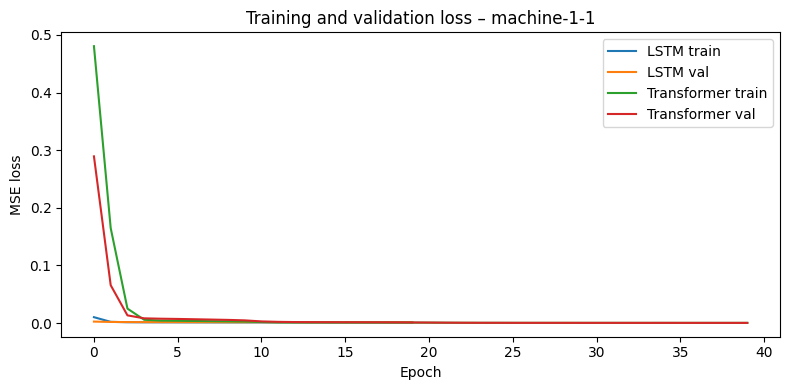

In [ ]:

# ==== 8.7 Loss Curves for LSTM vs Transformer ====

if 'hist_lstm' in globals() and 'hist_transf' in globals():
    plt.figure(figsize=(8,4))
    plt.plot(hist_lstm["train_loss"],   label="LSTM train")
    plt.plot(hist_lstm["val_loss"],     label="LSTM val")
    plt.plot(hist_transf["train_loss"], label="Transformer train")
    plt.plot(hist_transf["val_loss"],   label="Transformer val")
    plt.xlabel("Epoch")
    plt.ylabel("MSE loss")
    plt.title("Training and validation loss – machine-1-1")
    plt.legend()
    plt.tight_layout()
    plt.show()


### 8.8 Example: **feature-level diagnosis** with the Transformer model

Below we illustrate how to:

1. Compute feature-wise errors for the Transformer autoencoder.
2. Learn per-feature thresholds from the training windows.
3. Obtain a `(T, D)` binary matrix of anomalous dimensions.
4. Inspect, for a few anomalous timestamps, which features are flagged as anomalous.


In [ ]:

# ==== 8.8 Feature-level diagnosis with Transformer Autoencoder ====

if 'transf_model' in globals():
    print("\n=== Feature-level diagnosis (Transformer) ===")
    # 1. Compute feature-wise errors on train and test
    feat_errors_train_transf = compute_feature_level_errors(transf_model, train_windows)
    feat_errors_test_transf = compute_feature_level_errors(transf_model, test_windows)

    print("Feature-level error matrices:")
    print("  train:", feat_errors_train_transf.shape)
    print("  test :", feat_errors_test_transf.shape)

    # 2. Learn per-feature thresholds from training errors
    feat_thresholds_transf = choose_feature_thresholds(feat_errors_train_transf, quantile=0.995)

    # 3. Multi-label predictions per (time, feature)
    y_pred_feat_transf = compute_feature_level_predictions(feat_errors_test_transf, feat_thresholds_transf)
    print("Feature-level prediction matrix shape:", y_pred_feat_transf.shape)

    # 4. Inspect a few anomalous timestamps according to time-level Transformer detection
    if 'y_pred_transf' in globals():
        anomalous_times = np.where(y_pred_transf == 1)[0]
        print(f"Number of anomalous timestamps (time-level): {len(anomalous_times)}")

        for t in anomalous_times[:5]:  # show up to 5
            anomalous_features = np.where(y_pred_feat_transf[t] == 1)[0]
            print(f"t = {t:5d} | anomalous features (indices) = {anomalous_features}")
    else:
        print("Warning: 'y_pred_transf' not found – run the Transformer time-level detection first.")
else:
    print("Warning: 'transf_model' not found – train the Transformer model first.")



=== Feature-level diagnosis (Transformer) ===
Feature-level error matrices:
  train: (28479, 38)
  test : (28479, 38)
Feature-level prediction matrix shape: (28479, 38)
Number of anomalous timestamps (time-level): 3566
t =  3765 | anomalous features (indices) = [ 0  1  4  5  6  7  8  9 10 11 12 13 14 16 17 20 22 23 24 26 27 28 29 30
 31 32 33 36 37]
t =  3766 | anomalous features (indices) = [ 0  1  4  5  6  7  8  9 10 11 12 13 14 16 17 20 22 23 24 26 27 28 29 30
 31 32 33 36 37]
t =  3767 | anomalous features (indices) = [ 0  1  4  5  6  7  8  9 10 11 12 13 14 16 17 20 21 22 23 24 26 27 28 29
 30 31 32 33 35 36 37]
t =  3768 | anomalous features (indices) = [ 0  1  4  5  6  7  8  9 10 11 12 13 14 16 17 20 21 22 23 24 26 27 28 29
 30 31 32 33 35 36 37]
t =  3769 | anomalous features (indices) = [ 0  1  4  5  6  7  8  9 10 11 12 13 14 16 17 20 21 22 23 24 26 27 28 29
 30 31 32 33 35 36 37]


8.9 **Error scale and outlier filtering (Transformer)**: The goal of this analysis is to visualise how much the reconstruction error distributions for normal and anomalous timestamps overlap, and to qualitatively compare this behaviour with the narrative in the reference paper.

In [ ]:
# ==== 8.9 Error scale and outlier filtering (Transformer) ====

train_scores = np.asarray(train_errors_transf)
test_scores  = np.asarray(test_errors_transf)

print("Train scores shape:", train_scores.shape)
print("Test  scores shape:", test_scores.shape)
print("Train scores  min / max:", float(train_scores.min()), float(train_scores.max()))
print("Test  scores  min / max:", float(test_scores.min()),  float(test_scores.max()))

# Check and filter extreme values
test_scores = np.asarray(test_errors_transf)
mask_good = np.isfinite(test_scores) & (test_scores < 1e3)

print("Original test scores:", test_scores.shape)
print("Non-finite values:", np.sum(~np.isfinite(test_scores)))
print("Extremely large values:", np.sum(test_scores >= 1e3))

test_scores_filtered = test_scores[mask_good]
print("Filtered test scores:", test_scores_filtered.shape)
print("Filtered min/max:", test_scores_filtered.min(), test_scores_filtered.max())


Train scores shape: (28479,)
Test  scores shape: (28479,)
Train scores  min / max: 1.4743943211215083e-05 0.012073284946382046
Test  scores  min / max: 1.1620538316492457e-05 318174935384064.0
Original test scores: (28479,)
Non-finite values: 0
Extremely large values: 480
Filtered test scores: (27999,)
Filtered min/max: 1.1620538e-05 0.46418178


8.10 **Error distribution (normal vs anomaly)**:The goal of this analysis is to visualise how much the reconstruction error distributions for normal and anomalous timestamps overlap, and to qualitatively compare this behaviour with the narrative in the reference paper.

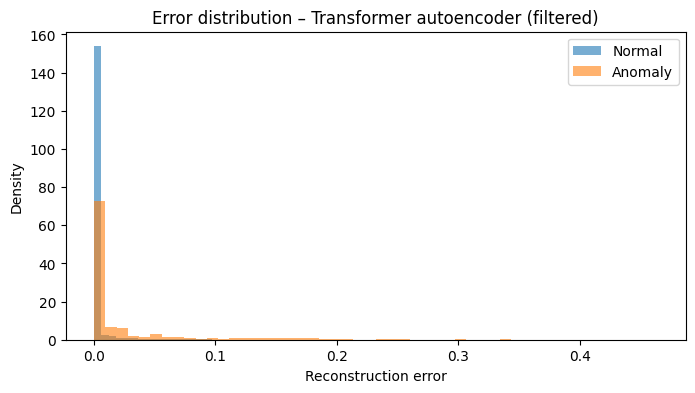

In [ ]:
# ==== 8.10 Error distribution: normal vs anomaly ====

import numpy as np
import matplotlib.pyplot as plt

test_scores = np.asarray(test_errors_transf)

# stesso filtro che hai già usato
mask_good = np.isfinite(test_scores) & (test_scores < 1e3)
scores_good   = test_scores[mask_good]
labels_good   = test_labels[mask_good]

normal_scores  = scores_good[labels_good == 0]
anomaly_scores = scores_good[labels_good == 1]

plt.figure(figsize=(8,4))
plt.hist(normal_scores,  bins=50, density=True, alpha=0.6, label="Normal")
plt.hist(anomaly_scores, bins=50, density=True, alpha=0.6, label="Anomaly")
plt.xlabel("Reconstruction error")
plt.ylabel("Density")
plt.title("Error distribution – Transformer autoencoder (filtered)")
plt.legend()
plt.show()



8.11 **Score vs ground truth (zoomed interval)**

In [ ]:
np.where(test_labels[3000:3800] == 1)[0]
# indici di tutti i timestamp anomali nel test set
anom_idx = np.where(test_labels == 1)[0]
anom_idx.min(), anom_idx.max()


(np.int64(15849), np.int64(27555))

In [ ]:
center = anom_idx[0]        # o anom_idx[100], ecc.
half_window = 200

t0 = max(0, center - half_window)
t1 = min(len(test_labels), center + half_window)

print(t0, t1)


15649 16049


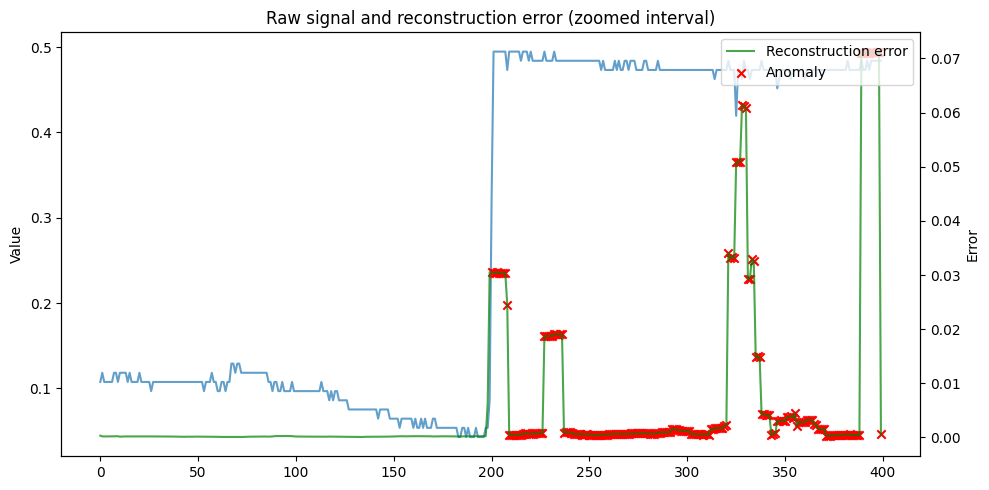

In [ ]:
plt.figure(figsize=(10, 5))

# 1) raw feature
plt.plot(test_data[t0:t1, 0], label='Feature 0 (raw)', alpha=0.7)
plt.ylabel("Value")

# 2) reconstruction error on second y-axis
plt.twinx()
test_scores = test_errors_transf
plt.plot(test_scores[t0:t1], label='Reconstruction error', alpha=0.7, color='green')
plt.ylabel("Error")

# 3) anomalies
anomalous_idx = np.where(test_labels[t0:t1] == 1)[0]
plt.scatter(anomalous_idx,
            test_scores[t0:t1][anomalous_idx],
            marker='x',
            label='Anomaly',
            color='red')

plt.title("Raw signal and reconstruction error (zoomed interval)")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

8.12 **Feature-wise error heatmap**: The objective is to approximate the “attention heatmaps” shown in the reference paper by visualising feature-wise reconstruction errors over time. Instead of attention weights, we use the MSE per feature to identify which dimensions are most affected during anomaly intervals.

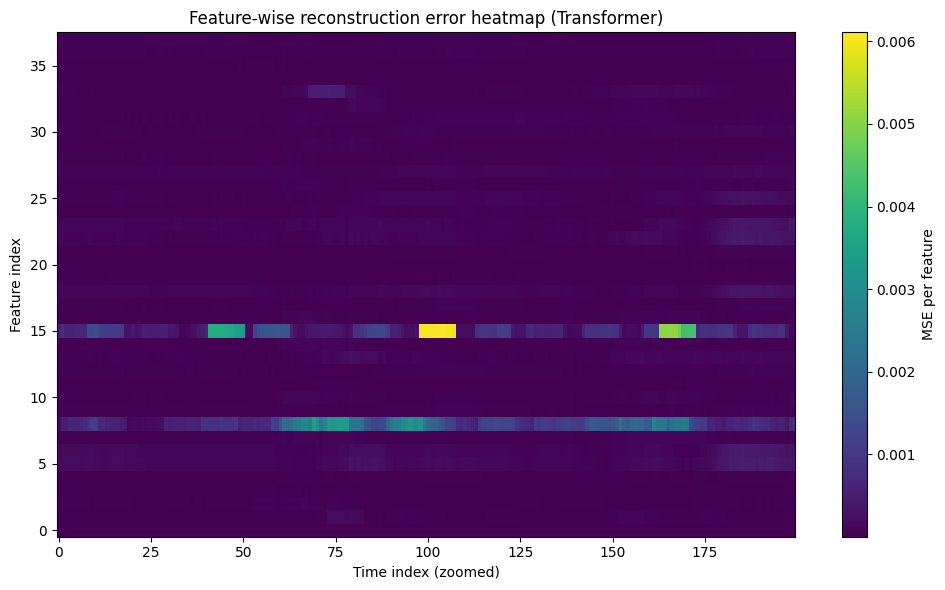

In [ ]:
# ==== 8.12 Feature-wise reconstruction error heatmap (Transformer) ====

window = slice(900, 1100)   # interval containing an anomaly
subset = feat_errors_test_transf[window, :].T  # (D, time)

plt.figure(figsize=(10, 6))
plt.imshow(subset, aspect='auto', origin='lower')
plt.colorbar(label='MSE per feature')
plt.xlabel("Time index (zoomed)")
plt.ylabel("Feature index")
plt.title("Feature-wise reconstruction error heatmap (Transformer)")
plt.tight_layout()
plt.show()


8.13 **Threshold sensitivity analysis**: The goal is to study how detection performance changes when varying the anomaly threshold, by sweeping different quantiles of the training error distribution (0.99, 0.995, 0.999). This analysis clarifies that our default threshold is intentionally tuned towards high recall and shows how more sophisticated models (such as TranAD) may exploit richer thresholding strategies.

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# ==== 8.13 Threshold sensitivity analysis (Transformer) ====


quantiles = [0.99, 0.995, 0.999]
results = []

# Use Transformer errors for sensitivity analysis
train_scores = train_errors_transf
test_scores = test_errors_transf

for q in quantiles:
    thr = np.quantile(train_scores, q)
    y_pred = (test_scores > thr).astype(int)
    prec = precision_score(test_labels, y_pred, zero_division=0)
    rec = recall_score(test_labels, y_pred, zero_division=0)
    f1 = f1_score(test_labels, y_pred, zero_division=0)
    results.append((q, thr, prec, rec, f1))

for q, thr, p, r, f1 in results:
    print(f"q={q:.3f}, thr={thr:.4f}, P={p:.3f}, R={r:.3f}, F1={f1:.3f}")


q=0.990, thr=0.0017, P=0.332, R=0.618, F1=0.432
q=0.995, thr=0.0027, P=0.356, R=0.542, F1=0.430
q=0.999, thr=0.0084, P=0.411, R=0.425, F1=0.418



# More improvement try
---



# ** Ablation: window size (K = 10, 30, 50) **

In [ ]:
# ==== 9.1 Window-size ablation: K = 10, 30, 50 ====

import numpy as np
import pandas as pd
import torch.nn as nn # Added import
import torch # Added import

# Redefine TransformerAELN to accept max_len for positional embedding
class TransformerAELN_Ablation(nn.Module):
    def __init__(self, input_dim: int, d_model: int = 64, nhead: int = 4, num_layers: int = 1, max_len: int = 10):
        super().__init__()

        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len, d_model)) # Use max_len here

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True,
            dropout=0.1,
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True,
            dropout=0.1,
            norm_first=True
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        self.output_proj = nn.Linear(d_model, input_dim)
        self.final_norm = nn.LayerNorm(input_dim)

    def forward(self, x):
        B, K, D = x.shape
        # Ensure positional embedding is sliced to match current sequence length K
        x = self.input_proj(x) + self.pos_embedding[:, :K, :]

        z = self.encoder(x)
        out = self.decoder(tgt=x, memory=z)
        out = self.output_proj(out)
        out = self.final_norm(out)
        return out

WINDOW_SIZES = [10, 30, 50]
EPOCHS_LSTM_ABL = 15     # puoi aumentare se hai tempo (20–30)
EPOCHS_TRANSF_ABL = 20   # idem

results_ws = []

for K in WINDOW_SIZES:
    print(f"\n\n=== Window size K = {K} ===")

    # 1) Reload and normalise data for the current machine
    train_data, test_data, test_labels = load_smd_machine(SMD_TRAIN_DIR, MACHINE_ID)
    train_norm, test_norm, data_min, data_max = min_max_normalize(train_data, test_data)

    # 2) Create sliding windows
    train_windows = create_sliding_windows(train_norm, K)
    test_windows  = create_sliding_windows(test_norm,  K)

    print("Train windows:", train_windows.shape, "Test windows:", test_windows.shape)

    # 3) Dataloaders
    train_loader, val_loader = create_dataloaders(
        train_windows, batch_size=BATCH_SIZE, val_ratio=0.2
    )

    input_dim = train_data.shape[1]

    # ------------ LSTM ------------
    print("\n[LSTM] Training...")
    lstm_model = LSTMAutoencoder(input_dim=input_dim, hidden_dim=64, latent_dim=32)
    _ = fit_model(lstm_model, train_loader, val_loader, num_epochs=EPOCHS_LSTM_ABL, lr=1e-3)

    train_errors_lstm = compute_reconstruction_errors(lstm_model, train_windows)
    test_errors_lstm  = compute_reconstruction_errors(lstm_model,  test_windows)

    thr_lstm = choose_threshold(train_errors_lstm, quantile=0.995)
    y_pred_lstm = compute_predictions(test_errors_lstm, thr_lstm)
    metrics_lstm = evaluate_anomaly_detection(test_labels, test_errors_lstm, y_pred_lstm)

    # ------------ Transformer (LayerNorm) ------------
    print("\n[Transformer LN] Training...")
    transf_model = TransformerAELN_Ablation( # Use the modified class here
        input_dim=input_dim,
        d_model=64,
        nhead=4,
        num_layers=1,
        max_len=K # Pass K as max_len
    )
    _ = fit_model(transf_model, train_loader, val_loader, num_epochs=EPOCHS_TRANSF_ABL, lr=1e-3)

    train_errors_transf = compute_reconstruction_errors(transf_model, train_windows)
    test_errors_transf  = compute_reconstruction_errors(transf_model,  test_windows)

    thr_transf = choose_threshold(train_errors_transf, quantile=0.995)
    y_pred_transf = compute_predictions(test_errors_transf, thr_transf)
    metrics_transf = evaluate_anomaly_detection(test_labels, test_errors_transf, y_pred_transf)

    # 4) Save results
    results_ws.append({
        "K": K,
        "model": "LSTM AE",
        **metrics_lstm
    })
    results_ws.append({
        "K": K,
        "model": "Transformer AE (LN)",
        **metrics_transf
    })

# 5) Summary table
df_ws = pd.DataFrame(results_ws)
print("\n=== Window-size ablation summary ===")
display(df_ws)




=== Window size K = 10 ===
Loaded SMD machine machine-1-1
Train shape: (28479, 38)
Test  shape: (28479, 38)
Labels shape: (28479,)
Number of anomalous points in test: 2694
Train windows: (28479, 10, 38) Test windows: (28479, 10, 38)

[LSTM] Training...
Epoch 001 | train_loss=0.010569 | val_loss=0.002463
Epoch 002 | train_loss=0.002172 | val_loss=0.002198
Epoch 003 | train_loss=0.001502 | val_loss=0.001692
Epoch 004 | train_loss=0.001258 | val_loss=0.001530
Epoch 005 | train_loss=0.001193 | val_loss=0.001528
Epoch 006 | train_loss=0.001153 | val_loss=0.001475
Epoch 007 | train_loss=0.001108 | val_loss=0.001413
Epoch 008 | train_loss=0.001079 | val_loss=0.001426
Epoch 009 | train_loss=0.001058 | val_loss=0.001346
Epoch 010 | train_loss=0.001047 | val_loss=0.001380
Epoch 011 | train_loss=0.001035 | val_loss=0.001376
Epoch 012 | train_loss=0.001025 | val_loss=0.001365
Epoch 013 | train_loss=0.001015 | val_loss=0.001318
Epoch 014 | train_loss=0.001008 | val_loss=0.001333
Epoch 015 | train

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 001 | train_loss=0.480927 | val_loss=0.289958
Epoch 002 | train_loss=0.167831 | val_loss=0.071165
Epoch 003 | train_loss=0.026942 | val_loss=0.013881
Epoch 004 | train_loss=0.005863 | val_loss=0.009438
Epoch 005 | train_loss=0.004589 | val_loss=0.008610
Epoch 006 | train_loss=0.004161 | val_loss=0.008150
Epoch 007 | train_loss=0.003805 | val_loss=0.007553
Epoch 008 | train_loss=0.003423 | val_loss=0.006652
Epoch 009 | train_loss=0.003093 | val_loss=0.006139
Epoch 010 | train_loss=0.002808 | val_loss=0.005478
Epoch 011 | train_loss=0.002441 | val_loss=0.004355
Epoch 012 | train_loss=0.001518 | val_loss=0.002502
Epoch 013 | train_loss=0.001120 | val_loss=0.001913
Epoch 014 | train_loss=0.001029 | val_loss=0.001741
Epoch 015 | train_loss=0.000987 | val_loss=0.001645
Epoch 016 | train_loss=0.000956 | val_loss=0.001600
Epoch 017 | train_loss=0.000929 | val_loss=0.001520
Epoch 018 | train_loss=0.000905 | val_loss=0.001460
Epoch 019 | train_loss=0.000885 | val_loss=0.001421
Epoch 020 | 

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 001 | train_loss=0.480510 | val_loss=0.289559
Epoch 002 | train_loss=0.160942 | val_loss=0.066778
Epoch 003 | train_loss=0.028327 | val_loss=0.016057
Epoch 004 | train_loss=0.006844 | val_loss=0.009703
Epoch 005 | train_loss=0.004750 | val_loss=0.008754
Epoch 006 | train_loss=0.004315 | val_loss=0.008256
Epoch 007 | train_loss=0.004006 | val_loss=0.007912
Epoch 008 | train_loss=0.003753 | val_loss=0.007460
Epoch 009 | train_loss=0.003421 | val_loss=0.006989
Epoch 010 | train_loss=0.003124 | val_loss=0.006600
Epoch 011 | train_loss=0.002904 | val_loss=0.006181
Epoch 012 | train_loss=0.002716 | val_loss=0.005631
Epoch 013 | train_loss=0.002514 | val_loss=0.004913
Epoch 014 | train_loss=0.002206 | val_loss=0.003731
Epoch 015 | train_loss=0.001555 | val_loss=0.001859
Epoch 016 | train_loss=0.000715 | val_loss=0.001068
Epoch 017 | train_loss=0.000567 | val_loss=0.000826
Epoch 018 | train_loss=0.000485 | val_loss=0.000659
Epoch 019 | train_loss=0.000413 | val_loss=0.000535
Epoch 020 | 

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 001 | train_loss=0.480393 | val_loss=0.290686
Epoch 002 | train_loss=0.164894 | val_loss=0.068504
Epoch 003 | train_loss=0.026779 | val_loss=0.015141
Epoch 004 | train_loss=0.006258 | val_loss=0.010280
Epoch 005 | train_loss=0.005027 | val_loss=0.009487
Epoch 006 | train_loss=0.004752 | val_loss=0.008912
Epoch 007 | train_loss=0.004393 | val_loss=0.008449
Epoch 008 | train_loss=0.004079 | val_loss=0.007941
Epoch 009 | train_loss=0.003751 | val_loss=0.007028
Epoch 010 | train_loss=0.003230 | val_loss=0.005507
Epoch 011 | train_loss=0.002701 | val_loss=0.004743
Epoch 012 | train_loss=0.002013 | val_loss=0.003090
Epoch 013 | train_loss=0.001216 | val_loss=0.002017
Epoch 014 | train_loss=0.000988 | val_loss=0.001611
Epoch 015 | train_loss=0.000904 | val_loss=0.001514
Epoch 016 | train_loss=0.000863 | val_loss=0.001396
Epoch 017 | train_loss=0.000837 | val_loss=0.001268
Epoch 018 | train_loss=0.000813 | val_loss=0.001222
Epoch 019 | train_loss=0.000785 | val_loss=0.001168
Epoch 020 | 

,K,model,precision,recall,f1,auc_roc,auc_pr
0,10,LSTM AE,0.185390,0.984410,0.312018,0.872383,0.496929
1,10,Transformer AE (LN),0.351588,0.448033,0.393994,0.843995,0.419542
2,30,LSTM AE,0.183540,1.000000,0.310154,0.893145,0.502447
3,30,Transformer AE (LN),0.373544,0.535635,0.440140,0.895752,0.448810
4,50,LSTM AE,0.212211,0.957313,0.347410,0.895684,0.466889
5,50,Transformer AE (LN),0.346598,0.501114,0.409774,0.881441,0.399032


# **Huber loss** + **LayerNorm** + **Dropout**

In [ ]:
# ==== 9.2.1 TransformerAELNDrop: LN + higher dropout ====

import torch
import torch.nn as nn

class TransformerAELNDrop(nn.Module):
    """
    Transformer autoencoder with LayerNorm, higher dropout and learned positional embeddings.
    """
    def __init__(self, input_dim=38, d_model=64, nhead=4, num_layers=1, max_len=512, dropout=0.3):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model

        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_embedding = nn.Embedding(max_len, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True,
            dropout=dropout,
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True,
            dropout=dropout,
            norm_first=True
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        self.output_proj = nn.Linear(d_model, input_dim)
        self.final_norm = nn.LayerNorm(input_dim)

    def forward(self, x):
        # x: (B, K, D)
        B, K, D = x.shape
        pos_ids = torch.arange(0, K, device=x.device).unsqueeze(0).repeat(B, 1)
        x = self.input_proj(x) + self.pos_embedding(pos_ids)
        z = self.encoder(x)
        out = self.decoder(tgt=x, memory=z)
        out = self.output_proj(out)
        out = self.final_norm(out)
        return out


# Training con HuberLoss **(SmoothL1)**

In [ ]:
# ==== 9.2.2 Transformer (LN + Dropout + Huber loss) ====

import torch.nn as nn
import numpy as np

def fit_model_huber(
    model: nn.Module,
    train_loader,
    val_loader,
    num_epochs: int = 20,
    lr: float = 1e-3,
    weight_decay: float = 1e-5,
    delta: float = 1.0
):
    """
    Training loop with Huber (SmoothL1) loss.
    """
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.SmoothL1Loss(beta=delta)  # Huber-style loss

    history = {"train_loss": [], "val_loss": []}

    for epoch in range(1, num_epochs + 1):
        # --- train ---
        model.train()
        total_train, n_train = 0.0, 0
        for batch in train_loader:
            x = batch.to(device).float()
            recon = model(x)
            loss = criterion(recon, x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train += loss.item() * x.size(0)
            n_train += x.size(0)
        train_loss = total_train / n_train

        # --- val ---
        model.eval()
        total_val, n_val = 0.0, 0
        with torch.no_grad():
            for batch in val_loader:
                x = batch.to(device).float()
                recon = model(x)
                loss = criterion(recon, x)
                total_val += loss.item() * x.size(0)
                n_val += x.size(0)
        val_loss = total_val / n_val

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        print(f"Epoch {epoch:03d} | train_loss={train_loss:.6f} | val_loss={val_loss:.6f}")

    return history

# ---- Run Huber Transformer on current machine and window size ----

print("\n=== 9.2 Transformer (LN + Dropout + Huber loss) ===")

# Usa gli stessi train_windows / test_windows / train_loader / val_loader già costruiti
# (per esempio con K=10 oppure K=30 se hai già fatto l'ablation)

transf_huber = TransformerAELNDrop(input_dim=input_dim, d_model=64, nhead=4, num_layers=1, dropout=0.3)
hist_transf_huber = fit_model_huber(
    transf_huber,
    train_loader,
    val_loader,
    num_epochs=20,
    lr=1e-3,
    delta=1.0
)

train_errors_huber = compute_reconstruction_errors(transf_huber, train_windows)
test_errors_huber  = compute_reconstruction_errors(transf_huber,  test_windows)

# soglia + metriche
thr_huber = choose_threshold(train_errors_huber, quantile=0.995)
y_pred_huber = compute_predictions(test_errors_huber, thr_huber)
metrics_huber = evaluate_anomaly_detection(test_labels, test_errors_huber, y_pred_huber)

print("\n[Transformer Huber] metrics:", metrics_huber)



=== 9.2 Transformer (LN + Dropout + Huber loss) ===


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 001 | train_loss=0.163600 | val_loss=0.111370
Epoch 002 | train_loss=0.082089 | val_loss=0.057613
Epoch 003 | train_loss=0.035837 | val_loss=0.008161
Epoch 004 | train_loss=0.003226 | val_loss=0.004681
Epoch 005 | train_loss=0.002513 | val_loss=0.004443
Epoch 006 | train_loss=0.002370 | val_loss=0.004209
Epoch 007 | train_loss=0.002188 | val_loss=0.003879
Epoch 008 | train_loss=0.001934 | val_loss=0.003598
Epoch 009 | train_loss=0.001680 | val_loss=0.003255
Epoch 010 | train_loss=0.001441 | val_loss=0.002907
Epoch 011 | train_loss=0.001259 | val_loss=0.002588
Epoch 012 | train_loss=0.001113 | val_loss=0.002333
Epoch 013 | train_loss=0.000980 | val_loss=0.002033
Epoch 014 | train_loss=0.000857 | val_loss=0.001752
Epoch 015 | train_loss=0.000736 | val_loss=0.001473
Epoch 016 | train_loss=0.000546 | val_loss=0.000845
Epoch 017 | train_loss=0.000237 | val_loss=0.000372
Epoch 018 | train_loss=0.000181 | val_loss=0.000311
Epoch 019 | train_loss=0.000152 | val_loss=0.000248
Epoch 020 | 

# Using 4 machines

In [ ]:
# ==== 9.3 Multi-machine evaluation (3–4 machines) ====

import numpy as np
import pandas as pd

MACHINES = [
    "machine-1-1",
    "machine-1-2",
    "machine-1-3",
    "machine-2-1"
]

K_MULTI = 10          # puoi anche usare 30 se hai già visto che funziona meglio
EPOCHS_MULTI = 20
BATCH_SIZE = 128

multi_results = []

for mid in MACHINES:
    print(f"\n\n===== Machine: {mid} =====")

    # 1) Load + normalise
    train_data, test_data, test_labels = load_smd_machine(SMD_TRAIN_DIR, mid)
    train_norm, test_norm, data_min, data_max = min_max_normalize(train_data, test_data)

    # 2) Windows
    train_windows = create_sliding_windows(train_norm, K_MULTI)
    test_windows  = create_sliding_windows(test_norm,  K_MULTI)
    print("Train windows:", train_windows.shape, "Test windows:", test_windows.shape)

    # 3) Dataloaders
    train_loader, val_loader = create_dataloaders(
        train_windows, batch_size=BATCH_SIZE, val_ratio=0.2
    )
    input_dim = train_data.shape[1]

    # 4) Train best Transformer variant (LN, 40 epochs or 20 per risparmiare tempo)
    transf_model = TransformerAELN(
        input_dim=input_dim,
        d_model=64,
        nhead=4,
        num_layers=1
    )
    _ = fit_model(transf_model, train_loader, val_loader, num_epochs=EPOCHS_MULTI, lr=1e-3)

    train_errors_transf = compute_reconstruction_errors(transf_model, train_windows)
    test_errors_transf  = compute_reconstruction_errors(transf_model,  test_windows)

    thr_transf = choose_threshold(train_errors_transf, quantile=0.995)
    y_pred_transf = compute_predictions(test_errors_transf, thr_transf)
    metrics_transf = evaluate_anomaly_detection(test_labels, test_errors_transf, y_pred_transf)

    print(f"[{mid}] Transformer metrics:", metrics_transf)

    row = {"machine": mid, **metrics_transf}
    multi_results.append(row)

# Summary table across machines
df_multi = pd.DataFrame(multi_results)
print("\n=== Multi-machine summary (Transformer) ===")
display(df_multi)

print("\n=== Average metrics across machines ===")
print(df_multi.mean(numeric_only=True))




===== Machine: machine-1-1 =====
Loaded SMD machine machine-1-1
Train shape: (28479, 38)
Test  shape: (28479, 38)
Labels shape: (28479,)
Number of anomalous points in test: 2694
Train windows: (28479, 10, 38) Test windows: (28479, 10, 38)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 001 | train_loss=0.477866 | val_loss=0.285973
Epoch 002 | train_loss=0.158073 | val_loss=0.065190
Epoch 003 | train_loss=0.026823 | val_loss=0.015606
Epoch 004 | train_loss=0.006474 | val_loss=0.009304
Epoch 005 | train_loss=0.004400 | val_loss=0.008364
Epoch 006 | train_loss=0.003990 | val_loss=0.007764
Epoch 007 | train_loss=0.003581 | val_loss=0.006891
Epoch 008 | train_loss=0.003170 | val_loss=0.005713
Epoch 009 | train_loss=0.002741 | val_loss=0.004751
Epoch 010 | train_loss=0.002226 | val_loss=0.003626
Epoch 011 | train_loss=0.001327 | val_loss=0.002319
Epoch 012 | train_loss=0.000974 | val_loss=0.001752
Epoch 013 | train_loss=0.000871 | val_loss=0.001495
Epoch 014 | train_loss=0.000829 | val_loss=0.001358
Epoch 015 | train_loss=0.000803 | val_loss=0.001284
Epoch 016 | train_loss=0.000783 | val_loss=0.001243
Epoch 017 | train_loss=0.000766 | val_loss=0.001212
Epoch 018 | train_loss=0.000749 | val_loss=0.001148
Epoch 019 | train_loss=0.000736 | val_loss=0.001133
Epoch 020 | 

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 001 | train_loss=0.587710 | val_loss=0.423330
Epoch 002 | train_loss=0.246065 | val_loss=0.131680
Epoch 003 | train_loss=0.059541 | val_loss=0.018645
Epoch 004 | train_loss=0.007246 | val_loss=0.003345
Epoch 005 | train_loss=0.002392 | val_loss=0.001862
Epoch 006 | train_loss=0.001730 | val_loss=0.001404
Epoch 007 | train_loss=0.001369 | val_loss=0.001209
Epoch 008 | train_loss=0.001185 | val_loss=0.001119
Epoch 009 | train_loss=0.001088 | val_loss=0.001058
Epoch 010 | train_loss=0.001028 | val_loss=0.001012
Epoch 011 | train_loss=0.000990 | val_loss=0.000994
Epoch 012 | train_loss=0.000964 | val_loss=0.000974
Epoch 013 | train_loss=0.000944 | val_loss=0.000961
Epoch 014 | train_loss=0.000928 | val_loss=0.000949
Epoch 015 | train_loss=0.000918 | val_loss=0.000941
Epoch 016 | train_loss=0.000908 | val_loss=0.000936
Epoch 017 | train_loss=0.000898 | val_loss=0.000925
Epoch 018 | train_loss=0.000890 | val_loss=0.000948
Epoch 019 | train_loss=0.000879 | val_loss=0.000897
Epoch 020 | 

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 001 | train_loss=0.458476 | val_loss=0.386933
Epoch 002 | train_loss=0.194535 | val_loss=0.156614
Epoch 003 | train_loss=0.052352 | val_loss=0.039148
Epoch 004 | train_loss=0.009949 | val_loss=0.029450
Epoch 005 | train_loss=0.007438 | val_loss=0.029053
Epoch 006 | train_loss=0.007071 | val_loss=0.028889
Epoch 007 | train_loss=0.006744 | val_loss=0.028568
Epoch 008 | train_loss=0.006364 | val_loss=0.028406
Epoch 009 | train_loss=0.005932 | val_loss=0.027396
Epoch 010 | train_loss=0.005577 | val_loss=0.026838
Epoch 011 | train_loss=0.005245 | val_loss=0.026518
Epoch 012 | train_loss=0.004909 | val_loss=0.025952
Epoch 013 | train_loss=0.004569 | val_loss=0.025091
Epoch 014 | train_loss=0.004209 | val_loss=0.024419
Epoch 015 | train_loss=0.003752 | val_loss=0.023931
Epoch 016 | train_loss=0.002038 | val_loss=0.022524
Epoch 017 | train_loss=0.000636 | val_loss=0.022328
Epoch 018 | train_loss=0.000403 | val_loss=0.022109
Epoch 019 | train_loss=0.000315 | val_loss=0.022438
Epoch 020 | 

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 001 | train_loss=0.559035 | val_loss=0.379994
Epoch 002 | train_loss=0.235205 | val_loss=0.125623
Epoch 003 | train_loss=0.053869 | val_loss=0.016912
Epoch 004 | train_loss=0.008886 | val_loss=0.004340
Epoch 005 | train_loss=0.004599 | val_loss=0.003259
Epoch 006 | train_loss=0.004064 | val_loss=0.003068
Epoch 007 | train_loss=0.003788 | val_loss=0.002815
Epoch 008 | train_loss=0.003556 | val_loss=0.002711
Epoch 009 | train_loss=0.003388 | val_loss=0.002544
Epoch 010 | train_loss=0.003258 | val_loss=0.002411
Epoch 011 | train_loss=0.003152 | val_loss=0.002285
Epoch 012 | train_loss=0.003064 | val_loss=0.002228
Epoch 013 | train_loss=0.002991 | val_loss=0.002168
Epoch 014 | train_loss=0.002925 | val_loss=0.002105
Epoch 015 | train_loss=0.002864 | val_loss=0.002081
Epoch 016 | train_loss=0.002806 | val_loss=0.002035
Epoch 017 | train_loss=0.002747 | val_loss=0.001976
Epoch 018 | train_loss=0.002688 | val_loss=0.001939
Epoch 019 | train_loss=0.002623 | val_loss=0.001904
Epoch 020 | 

,machine,precision,recall,f1,auc_roc,auc_pr
0,machine-1-1,0.358615,0.465108,0.404977,0.878250,0.448290
1,machine-1-2,0.621622,0.254613,0.361257,0.835182,0.378370
2,machine-1-3,0.065484,0.058752,0.061935,0.550728,0.075746
3,machine-2-1,0.894737,0.043590,0.083130,0.592146,0.162934



=== Average metrics across machines ===
precision    0.485114
recall       0.205515
f1           0.227825
auc_roc      0.714077
auc_pr       0.266335
dtype: float64


# Threshold smoothing: **moving average + std-boost**

In [ ]:
# ==== 9.4 Threshold smoothing: moving average + std-boost ====

import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Assumiamo che train_errors_transf_long e test_errors_transf_long
# siano gli errori del "miglior" Transformer (LN, 40 epochs, K scelto)
train_scores = np.asarray(train_errors_transf_long)
test_scores  = np.asarray(test_errors_transf_long)

print("Train scores:", train_scores.shape, "Test scores:", test_scores.shape)

# Fix: Reload test_labels for the specific machine that test_errors_transf_long corresponds to (machine-1-1)
_, _, y_true_fixed = load_smd_machine(SMD_TRAIN_DIR, MACHINE_ID)
# Ensure y_true_fixed is not None, otherwise default to existing test_labels if no label file
if y_true_fixed is not None:
    y_true = y_true_fixed
else:
    y_true = test_labels # Fallback to the last loaded test_labels, though this might still be incorrect if MACHINE_ID labels are missing.


# 1) Moving average smoothing on test scores
def moving_average(x, window=5):
    if window <= 1:
        return x
    kernel = np.ones(window) / window
    y = np.convolve(x, kernel, mode="same")
    return y

WINDOW_SMOOTH = 5
test_scores_smooth = moving_average(test_scores, window=WINDOW_SMOOTH)

# 2) Threshold strategies
# 2.a) Quantile-based (baseline)
q = 0.995
thr_quant = np.quantile(train_scores, q)

# 2.b) Mean + lambda * std (std-boost) on training scores
mu = train_scores.mean()
sigma = train_scores.std()
LAMBDA = 3.0   # 3 std above mean
thr_std = mu + LAMBDA * sigma

print(f"Quantile thr (q={q}): {thr_quant:.4f}")
print(f"Std-boost thr (mu + {LAMBDA}*sigma): {thr_std:.4f}")

# 3) Predictions
# y_true = test_labels  # Original line: this was causing the mismatch

# Without smoothing
y_pred_quant_raw = (test_scores >= thr_quant).astype(int)
y_pred_std_raw   = (test_scores >= thr_std).astype(int)

# With smoothing
y_pred_quant_smooth = (test_scores_smooth >= thr_quant).astype(int)
y_pred_std_smooth   = (test_scores_smooth >= thr_std).astype(int)

def compute_basic_metrics(y_true, y_pred):
    p = precision_score(y_true, y_pred, zero_division=0)
    r = recall_score(y_true, y_pred, zero_division=0)
    f = f1_score(y_true, y_pred, zero_division=0)
    return p, r, f

print("\n=== Threshold comparison (no smoothing) ===")
print("Quantile (raw):   P,R,F1 =", compute_basic_metrics(y_true, y_pred_quant_raw))
print("Std-boost (raw):  P,R,F1 =", compute_basic_metrics(y_true, y_pred_std_raw))

print("\n=== Threshold comparison (with smoothing, MA window=5) ===")
print("Quantile (smooth): P,R,F1 =", compute_basic_metrics(y_true, y_pred_quant_smooth))
print("Std-boost (smooth):P,R,F1 =", compute_basic_metrics(y_true, y_pred_std_smooth))


Train scores: (28479,) Test scores: (28479,)
Loaded SMD machine machine-1-1
Train shape: (28479, 38)
Test  shape: (28479, 38)
Labels shape: (28479,)
Number of anomalous points in test: 2694
Quantile thr (q=0.995): 0.0027
Std-boost thr (mu + 3.0*sigma): 0.0017

=== Threshold comparison (no smoothing) ===
Quantile (raw):   P,R,F1 = (0.35599415204678364, 0.5423162583518931, 0.4298323036187114)
Std-boost (raw):  P,R,F1 = (0.33213644524236985, 0.6180400890868597, 0.432074737251849)

=== Threshold comparison (with smoothing, MA window=5) ===
Quantile (smooth): P,R,F1 = (0.3622840690978887, 0.5605048255382331, 0.440104925677645)
Std-boost (smooth):P,R,F1 = (0.33634755258502064, 0.6351150705270973, 0.4397892301760699)
